In [9]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy import stats
from scipy.spatial import distance_matrix

from tqdm.notebook import tqdm
import warnings

from visuals import *
from my_lib import *
from my_lib import NWregression
%matplotlib inline

In [10]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

In [11]:
plt.rcParams['text.usetex'] = True

In [4]:
def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [17]:
def L1(previous_phi, phi):
    loss1 = np.zeros_like(phi)
    
    for i in range(len(phi)):
        loss1[i] = (1 - np.cos(max(0,previous_phi - phi[i])))/2

    return loss1

def L2(near_phis, phi):
    loss2 = np.zeros_like(phi)
    
    for i in range(len(phi)):
        for near_phi in near_phis:
            loss2[i] += (1 - np.cos(near_phi - phi[i]))/2

    return loss2

def L3(x, x_neigh, radius):
    x_array = np.full_like(x_neigh, x)
    
    loss3 = np.sum((x_array - x_neigh)**2, axis = 1)**.5/radius
    
    return loss3
    
dist = lambda x,y: np.sum((x-y)**2)**.5

def NearestNeighborsPhaseIdentifier(X, model, radius, epsilon = None, min_dim = 4, l1 = 1.0, l2 = 1.0, l3 = 1.0):

    """Compute phase for time series in phase space.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_dims)
        Input time series.
    
    model : array-like of shape (n_model_samples, n_dims)
    
    radius : float
        The radius of the area of deviations.
    
    epsilon: float (default = None)
        The radius of the search area for neighbors in the history.
    
    l1: float (default = 1.0)
        Coefficient of the first loss function.
        
    l2: float (default = 1.0)
        Coefficient of the second loss function.
        
    Returns
    -------
    
    phase_history : array-like of shape (n_model_samples, n_dims)
        Computed phase.
        
    
    ToDo
    -----
    
    """
    
    phase_history = []
    x_phase_history = {}
    n_model_points = len(model)
    model_phases = np.linspace(0,2*np.pi,n_model_points)
    
    model_NN = NearestNeighbors(n_neighbors = 1, radius = radius).fit(model)
    
    if epsilon is None:
        epsilon = radius
        
    for i in tqdm(range(len(X))):
        
        #ближайшие точка в начале алгоритма
        if len(phase_history) == 0:
            model_indeces = model_NN.kneighbors(np.array([X[i]]), return_distance=False)

            current_phi = model_phases[model_indeces]

            x_phase_history[float(current_phi)] = X[i]
            phase_history.append(float(current_phi))
            continue

        #ближайшие соседи на средней траектории
        model_indeces = model_NN.radius_neighbors(np.array([X[i]]), return_distance = False)
        possible_phi = model_phases[model_indeces[0]]
        
        #соседство с предысторией
        near_from_history = [phase_history for phase_history, x_history in x_phase_history.items() \
                             if dist(X[i],x_history) <= epsilon]
        near_from_history = np.array(near_from_history)

        #оптимизация
        idx_min = np.argmin(l1 * L1(phase_history[-1], possible_phi)
                            + l2 * L2(near_from_history, possible_phi)
                            + l3 * L3(X[i], model[model_indeces[0]], radius)
                           )
        
        current_phi = possible_phi[idx_min]

        #заполнение истории
        x_phase_history[float(current_phi)] = X[i]
        phase_history.append(float(current_phi))

    return np.array(phase_history)

In [18]:
def plot_peaks_on_PCA(peaks_idxs, X_PCA,
                      rotate=True,
                      save_name=None,
                     ):
    fig = plt.figure(figsize=(5, 5))
    axis = fig.add_subplot(111, projection='3d')
    Y_ = X_PCA[:, :3]
    if rotate:
        ax = 0/180 * np.pi
        ay = 90/180 * np.pi
        az = 30/180 * np.pi

        T_X = np.array([[1,0,0],
                        [0,np.cos(ax),-np.sin(ax)],
                        [0,np.sin(ax), np.cos(ax)]])

        T_Y = np.array([[np.cos(ay),-np.sin(ay),0],
                        [np.sin(ay), np.cos(ay),0],
                        [0,0,1]])

        T_Z = np.array([[ np.cos(az),0,np.sin(az)],
                        [ 0,1,0],
                        [-np.sin(az),0,np.cos(az)]])

        Y_ = Y_@T_Y@T_X
    axis.plot(Y_[:,0],
            Y_[:,1],
            Y_[:,2],
            lw = 1)

    axis.xaxis.set_rotate_label(False)
    axis.yaxis.set_rotate_label(False)
    axis.zaxis.set_rotate_label(False)
    axis.view_init(elev=20, azim=135)

    axis.grid(False)
    axis.xaxis.pane.set_edgecolor('black')
    axis.yaxis.pane.set_edgecolor('black')
    axis.xaxis.pane.fill = False
    axis.yaxis.pane.fill = False
    axis.zaxis.pane.fill = False
    
    axis.scatter(Y_[peaks_idxs, 0],
               Y_[peaks_idxs, 1],
               Y_[peaks_idxs, 2], marker="x", c="red")


    if save_name is not None:
        fig.tight_layout()
        fig.savefig(os.path.join('.', 'images_paper', f'{save_name}.eps'),
                    format='eps',
                    dpi=600,
                    bbox_inches='tight')

    fig.show()

# Walk



In [26]:
def find_phase(x_acc, 
               first_period_start=0, first_period_stop=454,
               n_components=4
              ):
    K = first_period_stop - first_period_start
    X_h = HankelMatrix(x_acc, K)

    pca = PCA(n_components=n_components)
    X_PCA = pca.fit_transform(X_h)
    first_period = first_period_stop - first_period_start

    phase = np.linspace(0, 2*np.pi, first_period).reshape((first_period, 1))

    metric = lambda x,y: (1 - np.cos((x-y)))/2

    model = NWregression(h = 0.005, metric = metric)

    model.fit(phase, X_PCA[first_period_start: first_period_stop])

    regression = model.predict(phase)

    D = np.max(np.min(distance_matrix(X_PCA, regression, p = 2),axis = 1)) * 2
    phase_history = NearestNeighborsPhaseIdentifier(X = X_PCA, model=regression, radius=D)
    return phase_history

In [75]:
x_acc, t = prepare_time_series('./data/long_walk_100_acc.csv',centred = False)

n_steps = 10
T = 462

dt = T * n_steps

x_acc = x_acc[7174: 7174 + dt]
fig = go.Figure()
fig.add_scatter(y = x_acc[:-T+1], mode='lines', name='x_acc')
peaks = scipy.signal.find_peaks(x_acc, distance=T//(1.3 + T/len(x_acc)))[0]
mask = np.array(peaks) > (len(x_acc) - T + 1)
if mask.any():
    peaks = peaks[~mask]
fig.add_scatter(x=peaks, y=x_acc[peaks], mode='markers', name='peaks')
fig.show()

In [76]:
from statsmodels.tsa.stattools import acf

In [77]:
len(x_acc)

4620

In [78]:
len(acf_result)

9240

In [93]:
def AutoCorrPhaseIdentifier(x, period, plot_acf = True):
    
    acf_result = acf(x[:], nlags = len(x), fft=True)
    
    if plot_acf:
        plt.plot(acf_result)
        
    acf_indeces_phase = scipy.signal.find_peaks(acf_result, distance = period * 0.75)[0]
    
    
    acf_indeces_phase = np.append(np.array([0]), acf_indeces_phase)
    phase = np.array([])
    for i in range(len(acf_indeces_phase)-1):
        i_start = acf_indeces_phase[i]
        i_end = acf_indeces_phase[i+1]
    
        phase = np.append(phase, np.linspace(0, 2*np.pi, int(i_end - i_start)))
    
    period_end = len(x) - acf_indeces_phase[-1]
    
    phase = np.append(phase, np.linspace(0, 2*np.pi*period_end/period, period_end))
    return phase

In [94]:
fig = go.Figure()
fig.add_scatter(y = acf_result,
                mode='lines',
                name='acf_result')

fig.show()

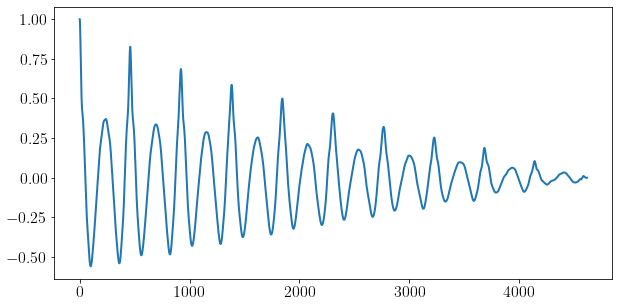

In [95]:
phase_autocorr = AutoCorrPhaseIdentifier(x = x_acc, period = 500, plot_acf = True)

In [28]:
peaks

array([  30,  480,  939, 1395, 1893, 2321, 2781, 3242, 3708])

In [29]:
walk_hand_peaks = np.array([  30,  480,  939, 1395, 1860, 2321, 2781, 3242, 3708])

In [30]:
# some random data
x = np.random.randn(1000)
y = np.random.randn(1000)

def plot_signal_phase(x_acc, phase, freq=500, save_path=None):
    
    def _scatter_phase(y, phase, ax, ax_phase, freq=500):
        # no labels
        ax.tick_params(axis="x", labelbottom=False)
        ax.set_ylabel('$s(t)$', size=20)
        # the scatter plot:
        ax.plot(y)

        # now determine nice limits by hand:
        binwidth = 0.25
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth

        ax_phase.plot(phase)
        ax_phase.set_yticks(np.linspace(0, 2*np.pi, 9))
        ax_phase.set_yticklabels([r"0",
                                  r"$\pi/4$",
                                  r"$\pi/2$",
                                  r"$3\pi/4$",
                                  r"$\pi$",
                                  r"$5\pi/4$",
                                  r"$3\pi/2$",
                                  r"$7\pi/4$",
                                  r"$2\pi$"])
        ax_phase.set_xticks(np.arange(len(y))[::freq])
        ax_phase.set_xticklabels(np.round(np.arange(len(y))/freq, 2)[::freq])
        ax_phase.set_xlabel('$t,c$', size=20)
        ax_phase.set_ylabel('$\phi(t)$', size=20)


    left, width = 0.1, 1.
    bottom, height = 0.1, 0.3
    spacing = 0.005


    rect_plot = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]

    # start with a square Figure
    fig = plt.figure(figsize=(8, 8))

    ax = fig.add_axes(rect_histx)
    ax_phasex = fig.add_axes(rect_plot, sharex=ax)

    # use the previously defined function
    _scatter_phase(x_acc, phase, ax, ax_phasex, freq=freq)
    if save_path is not None:
        fig.tight_layout()
        fig.savefig(save_path,
                    format='eps',
                    dpi=600,
                    bbox_inches='tight')
    plt.show()

In [31]:
phase_history = find_phase(x_acc, 0, 454)

In [110]:
x_acc[:-T+1].shape

(4159,)

In [108]:
phase_history.shape[0]

4167

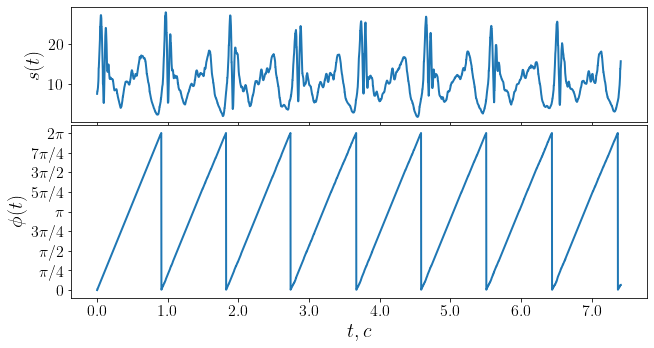

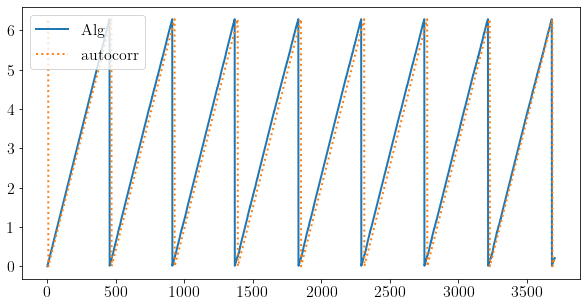

In [114]:
plot_signal_phase(x_acc[454-1:-T+1],
                  phase_history[:-T+1],
                  #save_path = os.path.join('..', 'PhaseIdentifier', 'images_paper', 'walk_retrieved_phase.eps')
                 )

plt.plot(phase_history[:-T+1], label = 'Alg')
plt.plot(phase_autocorr[454-1:-T+1], ':', label = 'autocorr')
plt.legend()

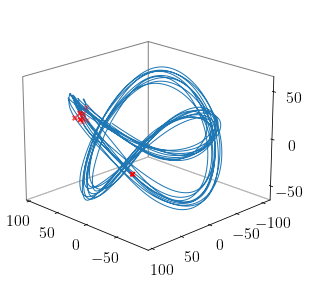

In [80]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

peaks = peaks[peaks < X_PCA.shape[0]]
    
plot_peaks_on_PCA(peaks, X_PCA,
                      rotate=True,
                     )

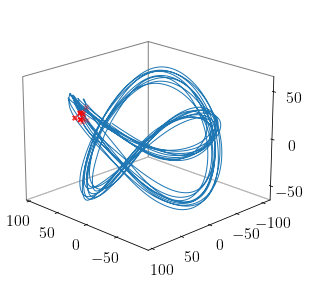

In [238]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

walk_hand_peaks = walk_hand_peaks[walk_hand_peaks < X_PCA.shape[0]]
    
plot_peaks_on_PCA(walk_hand_peaks, X_PCA,
                      rotate=True,
                     )

In [239]:
walk_hand_peaks

array([  30,  480,  939, 1395, 1860, 2321, 2781, 3242, 3708])

# Bicycle

In [60]:
T/len(x_acc)

0.05263157894736842

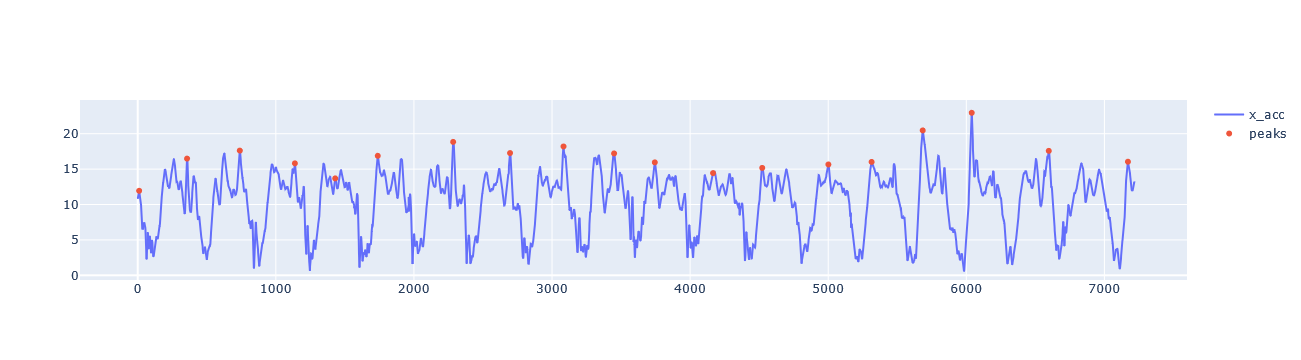

In [224]:
x_acc, t = prepare_time_series('./data/bike _accm.csv',centred = False)

x_acc = x_acc[15780:23000]
T = 380
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
peaks = scipy.signal.find_peaks(x_acc, distance=T//(1.3 + T/len(x_acc)))[0]
fig.add_scatter(x=peaks, y=x_acc[peaks], mode='markers', name='peaks')
fig.show()

In [225]:
peaks

array([  10,  357,  739, 1138, 1430, 1738, 2284, 2696, 3083, 3449, 3744,
       4166, 4522, 5001, 5314, 5684, 6039, 6597, 7170], dtype=int64)

In [226]:
peaks_with_hands = np.array([357,  739, 1138, 1472, 1905, 2284, 2696, 3083, 3449, 3893,
       4286, 4696, 5001, 5477, 5799, 6196, 6597, 6961])

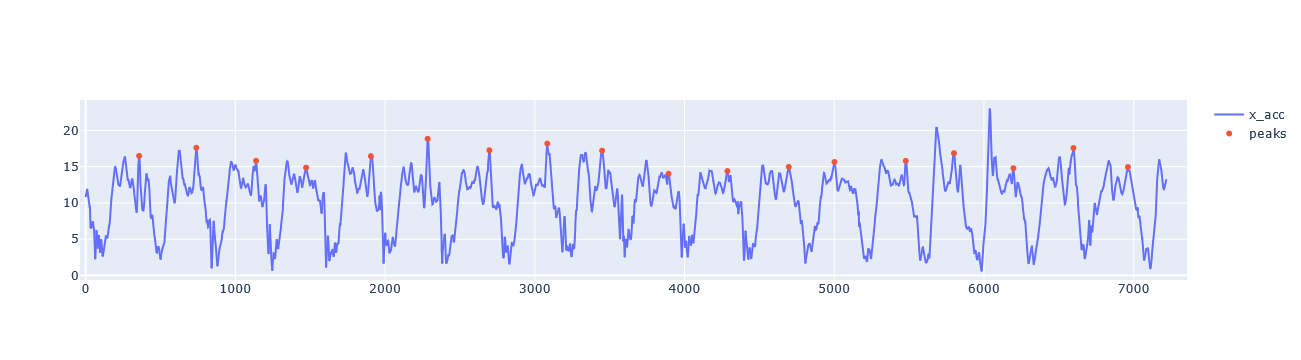

In [228]:
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
fig.add_scatter(x=peaks_with_hands, y=x_acc[peaks_with_hands], mode='markers', name='peaks')
fig.show()

In [ ]:
phase_byc = find_phase(x_acc, 0, 380)

Failed to find a Ghostscript installation.  Distillation step skipped.


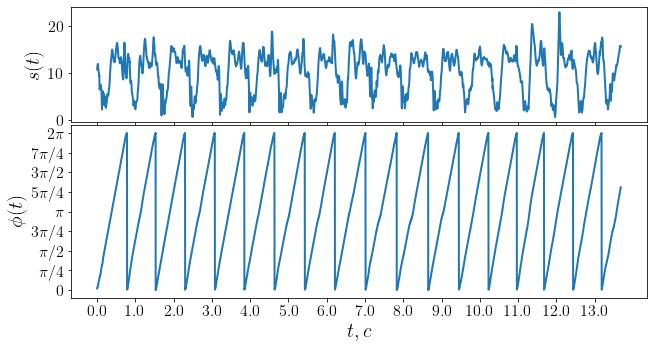

In [192]:
plot_signal_phase(x_acc[380-1:-T+1],
                  phase_byc[:-T+1],
                  save_path=os.path.join('..', 'PhaseIdentifier', 'images_paper', 'bycicle_retrieved_phase.eps'))

In [230]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

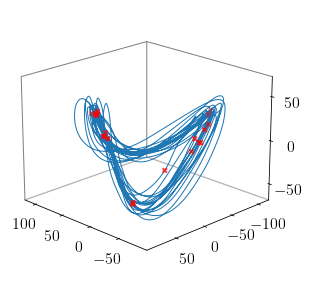

In [95]:
peaks = peaks[peaks < X_PCA.shape[0]]
    
plot_peaks_on_PCA(peaks, X_PCA,
                      rotate=True,
                     )

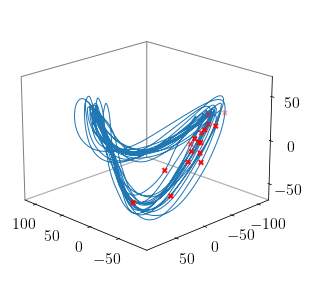

In [233]:
peaks_filtered = peaks_with_hands[peaks_with_hands < X_PCA.shape[0]]
plot_peaks_on_PCA(peaks_filtered, X_PCA,
                      rotate=True,
                     )

In [234]:
peaks_filtered

array([ 357,  739, 1138, 1472, 1905, 2284, 2696, 3083, 3449, 3893, 4286,
       4696, 5001, 5477, 5799, 6196, 6597])

# Squats

In [200]:
x_acc, t = prepare_time_series('./data/squats_accm.csv',centred = False)
T = 750
x_acc = x_acc[3670:14187]

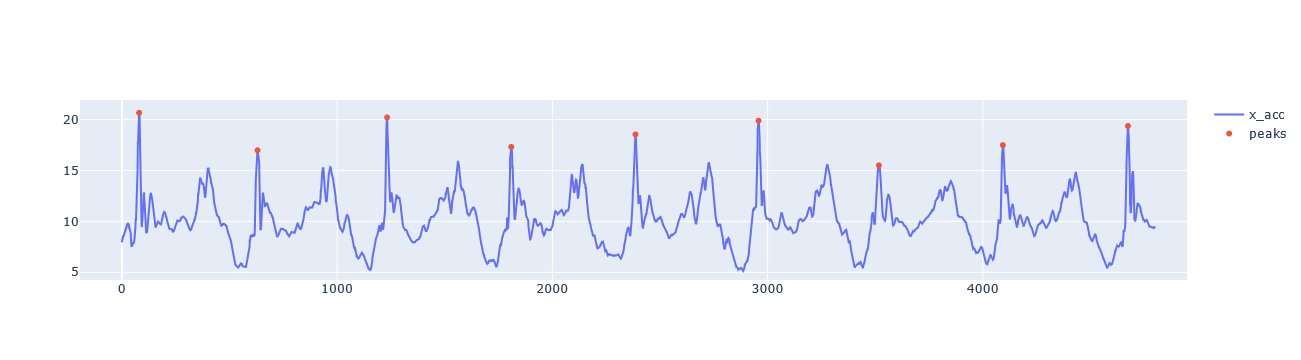

In [222]:
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
peaks = scipy.signal.find_peaks(x_acc, distance=T//(1.3 + T/len(x_acc)))[0]
fig.add_scatter(x=peaks, y=x_acc[peaks], mode='markers', name='peaks')
fig.show()

In [223]:
peaks

array([  80,  630, 1232, 1809, 2386, 2958, 3517, 4093, 4674], dtype=int64)

In [210]:
phase_sq = find_phase(x_acc[:10000], 0, 750)

  0%|          | 0/9251 [00:00<?, ?it/s]

Failed to find a Ghostscript installation.  Distillation step skipped.


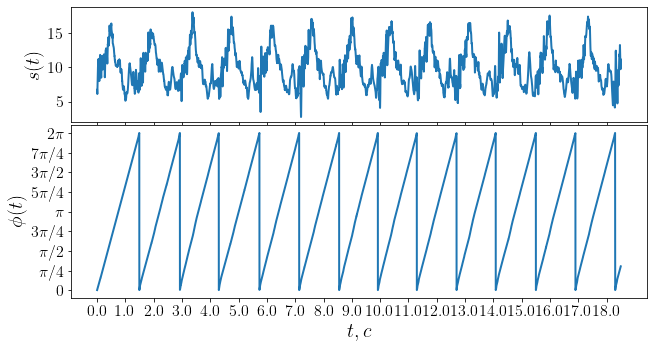

In [213]:
plot_signal_phase(x_acc[:10000][:-T+1], phase_sq , save_path=os.path.join('..', 'PhaseIdentifier', 'images_paper', 'squats_retrieved_phase.eps'))

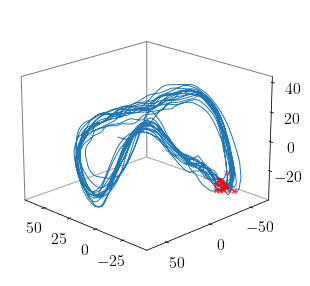

In [74]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

peaks = peaks[peaks < X_PCA.shape[0]]
    
plot_peaks_on_PCA(peaks, X_PCA,
                      rotate=True,
                     )

# Stairs

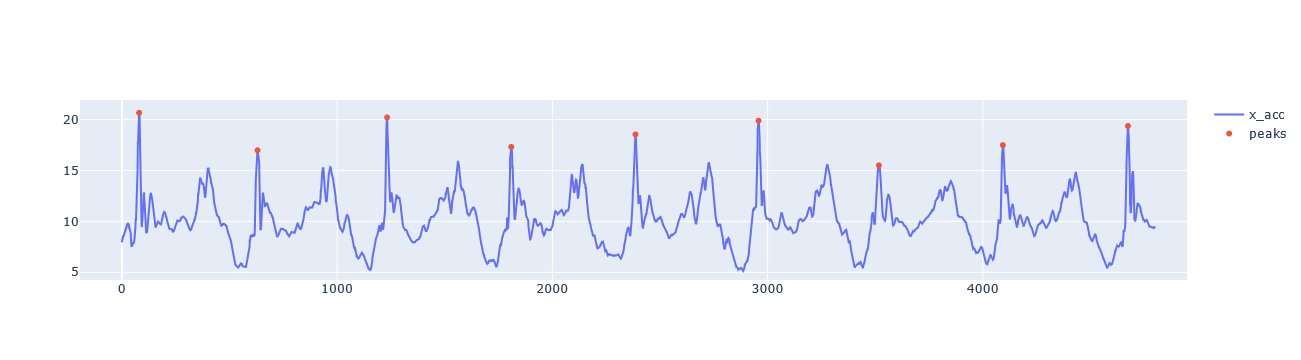

In [214]:
x_acc, t = prepare_time_series('./data/stairs_acc.csv',centred = False)

x_acc = x_acc[2100:6900]
T = 630 - 80
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
peaks = scipy.signal.find_peaks(x_acc, distance=T//(1.3 + T/len(x_acc)))[0]
fig.add_scatter(x=peaks, y=x_acc[peaks], mode='markers', name='peaks')
fig.show()

In [219]:
peaks

array([  80,  630, 1232, 1809, 2386, 2958, 3517, 4093, 4674], dtype=int64)

In [220]:
phase_st = find_phase(x_acc, 80, 630)

  0%|          | 0/4251 [00:00<?, ?it/s]

Failed to find a Ghostscript installation.  Distillation step skipped.


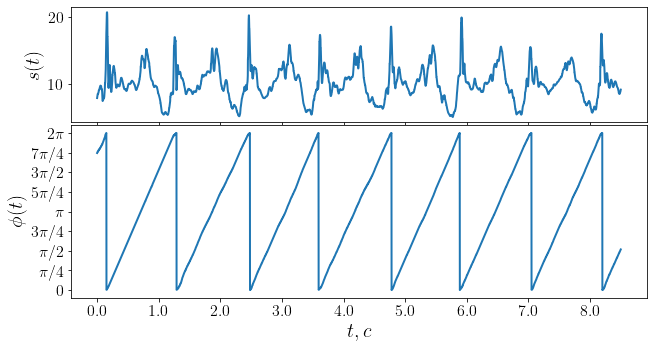

In [221]:
plot_signal_phase(x_acc[:-T+1], phase_st , save_path=os.path.join('..', 'PhaseIdentifier', 'images_paper', 'stairs_retrieved_phase.eps'))

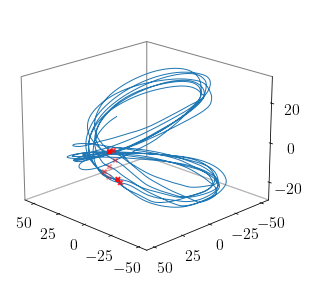

In [78]:
X_h = HankelMatrix(x_acc, 500)
pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

peaks = peaks[peaks < X_PCA.shape[0]]
    
plot_peaks_on_PCA(peaks, X_PCA,
                      rotate=True,
                     )